# Resampling & Registering Rasters w. Rasterio and Rioxarray

## Why is Resampling Important?
*Before you begin* any analysis using rater data it is critical that you have rasters that are "co-registered". Co-registration requires that any two rasters have the same resolution, and orientation - the origins can differ but they much align. *In other words, co-registration requires that cell centroids align perfectly for all intersecting areas.* Resampling is also extremely common during reprojection operations as it often requires changing the orientation, scale or resolution of an image. 

**Examples of data that is *not* co-registered**

<div align="center">
<img src="../../pygis/_static/e_raster/Raster_diff-orientation.jpg" alt="Resampling rasters - different orientation" width="400" style="display: block; margin: 0 auto;">
<p><em>Resampling rasters - different orientation</em></p>
</div>

<div align="center">
<img src="../../pygis/_static/e_raster/Raster_diff-orientation-origin.jpg" alt="Resampling rasters - different orientation and origin" width="400" style="display: block; margin: 0 auto;">
<p><em>Resampling rasters - different orientation and origin</em></p>
</div>

<div align="center">
<img src="../../pygis/_static/e_raster/Raster_diff-res.jpg" alt="Resampling rasters - different resolution" width="400" style="display: block; margin: 0 auto;">
<p><em>Resampling rasters - different resolution</em></p>
</div>
We can co-register images by resampling, and often reprojecting, one image to match another. 

## Methods for Resampling Explained
There are [a number of methods](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling) to resample data, but they often take the form of "nearest neighbor", "bilinear", and "cubic convolussion" - these interpolation methods [are explained here in some detail](d_raster_crs_intro_interpolation_options.md). But there are a number of other including: ['average', 'cubic_spline', 'gauss', 'lanczos', 'max', 'med', 'min', 'mode', 'nearest']. 

**resampling direction**
- Upsampling - converting to higher resolution/smaller cells. 
- Downsampling - converting to lower resolution/larger cell sizes.


## Simple Up/Downsampling in Rasterio & Rioxarray
### Rasterio Upsampling Example
Occasionally you will need to resample your data by some factor, for instance you might want data upsampled to a coarser resolution due to memory constraints. 


Here's an example of how to generate the `data` array and the `transform` needed to write it out. We will start by simply reading in the data and coercing a higher resolution, by adding more rows and columns. To understand the `transform`, let's review affine transformations. Here we will update the scale values with the new resolution using $S_{y}$ and $S_{x}$ shown below

$$
   \begin{eqnarray}
   \mbox{Scale transform: }  \begin{bmatrix} S_{x} & 0 & 0 \\ 0 & S_{y} & 0 \\ 0 & 0 & 1 \end{bmatrix} 
   \end{eqnarray}
$$

In [1]:
import rasterio
from rasterio.enums import Resampling

image = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

upscale_factor = 2

with rasterio.open(image) as dataset:

    # resample data to target shape using upscale_factor
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data.shape[1:])

    # scale image transform
    dst_transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    print('Transform before resample:\n', dataset.transform, '\n')
    print('Transform after resample:\n', dst_transform)

    ## Write outputs
    # set properties for output
    dst_kwargs = dataset.meta.copy()
    dst_kwargs.update(
        {
            "transform": dst_transform,
            "width": data.shape[-1],
            "height": data.shape[-2],
            "nodata": 0,  
        }
    )

    with rasterio.open("../../pygis/temp/LC08_20200518_15m.tif", "w", **dst_kwargs) as dst:
        # iterate through bands
        for i in range(data.shape[0]):
            dst.write(data[i].astype(rasterio.uint32), i+1)

Shape before resample: (1860, 2041)
Shape after resample: (3720, 4082)
Transform before resample:
 | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00| 

Transform after resample:
 | 15.00, 0.00, 717345.00|
| 0.00,-15.00,-2776995.00|
| 0.00, 0.00, 1.00|


Read up on affine transformations to help you understand the `transform.scale` function above. 


### Rioxarray Up/Down Sampling Example
As always the easiest way to deal with resampling is by deploying rioxarray. It's like a swiss army knife for kicking raster butt. Here we just need to set the desired resolution with `resolution`, and the `resampling` method in the reproject statement. We have a number of resampling methods available depending on the context listed above. Writing a file is a bit more intuitive too.

In [2]:
import rioxarray as rxr
from rasterio.enums import Resampling

image = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

# Open with rioxarray
src = rxr.open_rasterio(image)

print("Original data:")
print(src)

# Convert to float to avoid data type issues during resampling
src = src.astype('float32')

# Resample to 15m resolution using bilinear resampling
src_resampled = src.rio.reproject(
    src.rio.crs,  # Keep same CRS
    resolution=15,  # Set target resolution to 15m
    resampling=Resampling.bilinear
)

print("Resampled data:")
print(src_resampled)

# Save resampled version
src_resampled.rio.to_raster(
    "../../pygis/temp/LC08_20200518_15m.tif",
    compress='lzw',
    tiled=True,
    nodata=0
)

Original data:
<xarray.DataArray (band: 3, y: 1860, x: 2041)> Size: 23MB
[11388780 values with dtype=uint16]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 16kB 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
  * y            (y) float64 15kB -2.777e+06 -2.777e+06 ... -2.833e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
Resampled data:
<xarray.DataArray (band: 3, y: 3720, x: 4082)> Size: 182MB
array([[[   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        ...,
        [7583.5   , 7594.6875, 7617.0625, ..., 7419.3125, 7419.9375,
         7420.25  ],
        [7578.5   , 7610.0625, 7673.1875, ..., 7428.9375, 7416.8125,
         7410.75  ],
        [7576.    , 7617.75  , 7701.25

Much.... easier.... 


## Co-registering Rasters (Aligning cells)
One common problem is how to get raster data to align on a cell by cell basis so you can complete your analysis. We will walk through how to do this for both rasterio and rioxarray. In the following example we will learn how to align rasters with different origins, resolutions, or orientations. 

Our example data will look at registering LandSat data with precipitation data from CHIRPS. 

### Example of Co-registering Rasters with Rasterio
Co-registering data is a bit complicated with rasterio, you simply need to choose an "reference image" to match the bounds, CRS, and cell size. 

The original input data LandSat data is 30 meters and will be downsampled to match `precip` which is 500m.  Also note the use of `nodata` to avoid missing values stored as 0. Note we can choose a number of `resampling` techniques listed above. For more detail on resampling go to "Introduction to Raster CRS" chapter.

In [3]:
from rasterio.warp import reproject, Resampling, calculate_default_transform
import rasterio
def reproj_match(infile, match, outfile):
    """Reproject a file to match the shape and projection of existing raster. 
    
    Parameters
    ----------
    infile : (string) path to input file to reproject
    match : (string) path to raster with desired shape and projection 
    outfile : (string) path to output file tif
    """
    # open input
    with rasterio.open(infile) as src:
        src_transform = src.transform
        
        # open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs
            
            # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,     # input CRS
                dst_crs,     # output CRS
                match.width,   # input width
                match.height,  # input height 
                *match.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({"crs": dst_crs,
                           "transform": dst_transform,
                           "width": dst_width,
                           "height": dst_height,
                           "nodata": 0})
        print("Coregistered to shape:", dst_height,dst_width,'\n Affine',dst_transform)
        # open output
        with rasterio.open(outfile, "w", **dst_kwargs) as dst:
            # iterate through bands and write using reproject function
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)



Now we can execute our code to co-register two rasters

In [4]:
LS = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
precip = "../../pygis/data/precipitation_20200601_500m.tif"

# co-register LS to match precip raster
reproj_match(infile = LS, 
             match= precip,
             outfile = '../../pygis/temp/LS_reg_precip.tif')

Coregistered to shape: 136 157 
 Affine | 0.00, 0.00,-61.49|
| 0.00,-0.00,-0.00|
| 0.00, 0.00, 1.00|


### Example of Co-registering Rasters with Rioxarray
Co-registering data is simple in rioxarray, you simply need to choose a "reference image" to match the bounds, CRS, and cell size. 

The original input data `precip` is currently 500m but will be upsampled to 30m as seen in `print(src)`.  Also note the use of `nodata` to avoid missing values stored as -9999. Note we can choose a number of `resampling` techniques listed above. For more detail on resampling go to "Introduction to Raster CRS".

Reference image shape: (3, 1860, 2041)
Reference CRS: EPSG:32621
Reference resolution: (30.0, -30.0)
Original precipitation shape: (1, 135, 157)
Original precipitation CRS: EPSG:4326
Reprojected precipitation shape: (1, 1860, 2041)
Data range: 41.77 to 70.21


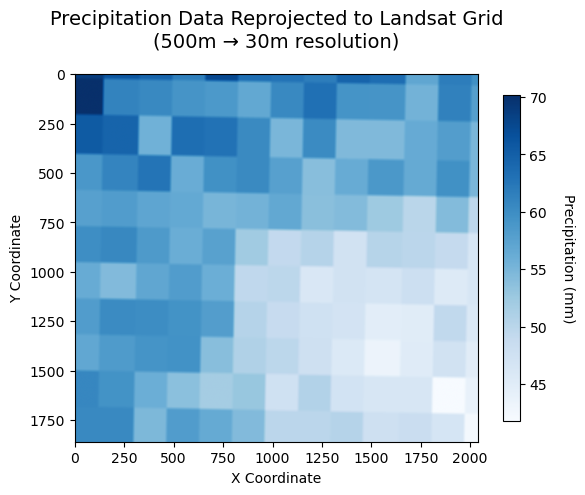


Reprojection Summary:
Original resolution: ~500m
New resolution: 30.0m
Resampling method: Bilinear
Output file: precip_20200601_30m.tif


In [9]:
import rioxarray as rxr
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import numpy as np

# Set up figure with proper size and DPI
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)

LS = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
precip = "../../pygis/data/precipitation_20200601_500m.tif"

# Open the reference image to get its spatial properties
ref_img = rxr.open_rasterio(LS)
print(f"Reference image shape: {ref_img.shape}")
print(f"Reference CRS: {ref_img.rio.crs}")
print(f"Reference resolution: {ref_img.rio.resolution()}")

# Open precipitation data
src_precip = rxr.open_rasterio(precip)
print(f"Original precipitation shape: {src_precip.shape}")
print(f"Original precipitation CRS: {src_precip.rio.crs}")

# Set nodata value
src_precip = src_precip.rio.write_nodata(-9999)

# Convert to float to avoid data type issues during resampling
src_precip = src_precip.astype('float32')

# Reproject precipitation to match the reference image's CRS, resolution, and extent
src = src_precip.rio.reproject_match(
    ref_img,
    resampling=Resampling.bilinear
)

print(f"Reprojected precipitation shape: {src.shape}")
print(f"Data range: {src.min().values:.2f} to {src.max().values:.2f}")

# Create a proper visualization with colorbar and title
# Mask nodata values for better visualization
data_masked = np.ma.masked_where(src.data[0] == -9999, src.data[0])

im = ax.imshow(data_masked, 
               cmap='Blues',  # Good colormap for precipitation
               aspect='equal')  # Maintain proper aspect ratio

# Add colorbar with label
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Precipitation (mm)', rotation=270, labelpad=20)

# Set title and labels
ax.set_title('Precipitation Data Reprojected to Landsat Grid\n(500m → 30m resolution)', 
             fontsize=14, pad=20)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Remove tick marks if desired for cleaner look
ax.tick_params(labelsize=10)

# Write out the matched data
src.rio.to_raster(
    "../../pygis/temp/precip_20200601_30m.tif",
    compress='lzw',
    tiled=True,
    nodata=-9999
)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nReprojection Summary:")
print(f"Original resolution: ~500m")
print(f"New resolution: {abs(src.rio.resolution()[0]):.1f}m")
print(f"Resampling method: Bilinear")
print(f"Output file: precip_20200601_30m.tif")

Although it's a bit hard to tell, the cell size is now 30m (see the slices of the larger original cells at the top of the image).